In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTConfig
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths
output_folder = './split-dataset-2'  # Output folder for the split dataset

# Training parameters
image_size = 224  # ViT typically uses 224x224 images
batch_size = 48
num_classes = 2  # Number of classes: maize and turmeric
learning_rate = 0.00001
num_epochs = 50

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoader
train_dataset = datasets.ImageFolder(os.path.join(output_folder, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(output_folder, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(output_folder, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

config = ViTConfig(
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=16,
    image_size=image_size,
    patch_size=16,
    num_labels=num_classes,
    dropout_rate=0.05
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the ViT model for classification
model = ViTForImageClassification(config)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
vit_val_accuracies = []
vit_train_losses = [] 

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    vit_train_losses.append(avg_loss)
    print(f"Training Loss: {avg_loss:.4f}")
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    vit_val_accuracies.append(accuracy)

print("Training complete.")

# Evaluation on test set
model.eval()
true_labels = []
predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Calculate metrics
vit_accuracy = accuracy_score(true_labels, predictions)
vit_precision = precision_score(true_labels, predictions, average='weighted')
vit_recall = recall_score(true_labels, predictions, average='weighted')
vit_f1 = f1_score(true_labels, predictions, average='weighted')

# Print metrics
print(f"Accuracy: {vit_accuracy:.4f}")
print(f"Precision: {vit_precision:.4f}")
print(f"Recall: {vit_recall:.4f}")
print(f"F1 Score: {vit_f1:.4f}")

del model
# Clear GPU memory
torch.cuda.empty_cache()


Using device: cuda


Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:17<00:00,  1.30it/s]


Training Loss: 0.1983
Validation Accuracy: 94.34%


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:12<00:00,  1.32it/s]


Training Loss: 0.1297
Validation Accuracy: 95.21%


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:13<00:00,  1.31it/s]


Training Loss: 0.0928
Validation Accuracy: 97.63%


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:12<00:00,  1.32it/s]


Training Loss: 0.0727
Validation Accuracy: 97.58%


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:13<00:00,  1.31it/s]


Training Loss: 0.0624
Validation Accuracy: 98.08%


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:13<00:00,  1.31it/s]


Training Loss: 0.0593
Validation Accuracy: 98.36%


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:12<00:00,  1.32it/s]


Training Loss: 0.0551
Validation Accuracy: 98.44%


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0525
Validation Accuracy: 98.36%


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0473
Validation Accuracy: 98.53%


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0426
Validation Accuracy: 98.72%


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0396
Validation Accuracy: 98.01%


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:13<00:00,  1.31it/s]


Training Loss: 0.0365
Validation Accuracy: 98.93%


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:12<00:00,  1.31it/s]


Training Loss: 0.0305
Validation Accuracy: 98.74%


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0299
Validation Accuracy: 98.36%


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0287
Validation Accuracy: 97.61%


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0244
Validation Accuracy: 98.55%


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0228
Validation Accuracy: 98.53%


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0223
Validation Accuracy: 98.84%


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0190
Validation Accuracy: 98.53%


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:12<00:00,  1.32it/s]


Training Loss: 0.0177
Validation Accuracy: 98.77%


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0181
Validation Accuracy: 97.70%


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0165
Validation Accuracy: 98.67%


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0159
Validation Accuracy: 98.53%


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0124
Validation Accuracy: 98.93%


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0148
Validation Accuracy: 98.79%


Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0181
Validation Accuracy: 98.67%


Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0103
Validation Accuracy: 98.67%


Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:12<00:00,  1.31it/s]


Training Loss: 0.0093
Validation Accuracy: 98.67%


Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:14<00:00,  1.31it/s]


Training Loss: 0.0099
Validation Accuracy: 98.46%


Epoch 30/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:14<00:00,  1.31it/s]


Training Loss: 0.0089
Validation Accuracy: 99.03%


Epoch 31/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:14<00:00,  1.31it/s]


Training Loss: 0.0120
Validation Accuracy: 98.77%


Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:12<00:00,  1.31it/s]


Training Loss: 0.0065
Validation Accuracy: 98.84%


Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0089
Validation Accuracy: 98.72%


Epoch 34/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:12<00:00,  1.32it/s]


Training Loss: 0.0074
Validation Accuracy: 98.70%


Epoch 35/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:13<00:00,  1.31it/s]


Training Loss: 0.0076
Validation Accuracy: 98.34%


Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:14<00:00,  1.31it/s]


Training Loss: 0.0088
Validation Accuracy: 98.82%


Epoch 37/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:14<00:00,  1.31it/s]


Training Loss: 0.0053
Validation Accuracy: 98.86%


Epoch 38/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:13<00:00,  1.31it/s]


Training Loss: 0.0110
Validation Accuracy: 98.53%


Epoch 39/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:14<00:00,  1.31it/s]


Training Loss: 0.0020
Validation Accuracy: 98.65%


Epoch 40/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:13<00:00,  1.31it/s]


Training Loss: 0.0106
Validation Accuracy: 98.65%


Epoch 41/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:13<00:00,  1.31it/s]


Training Loss: 0.0067
Validation Accuracy: 98.74%


Epoch 42/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:13<00:00,  1.31it/s]


Training Loss: 0.0056
Validation Accuracy: 98.91%


Epoch 43/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0068
Validation Accuracy: 98.86%


Epoch 44/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0013
Validation Accuracy: 98.77%


Epoch 45/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0059
Validation Accuracy: 98.48%


Epoch 46/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0088
Validation Accuracy: 98.46%


Epoch 47/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0067
Validation Accuracy: 98.51%


Epoch 48/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0032
Validation Accuracy: 98.29%


Epoch 49/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0053
Validation Accuracy: 98.86%


Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [05:11<00:00,  1.32it/s]


Training Loss: 0.0089
Validation Accuracy: 98.84%
Training complete.
Accuracy: 0.9858
Precision: 0.9857
Recall: 0.9858
F1 Score: 0.9857


In [3]:
# Parameters
image_size = 224
batch_size = 48  # Increase batch size
num_classes = 2  # maize and turmeric
learning_rate = 0.001 
num_epochs = 50 

# Data transformation
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 3.0 * torch.randn_like(x)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset directories
output_folder = './split-dataset-2'
train_dataset = datasets.ImageFolder(os.path.join(output_folder, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(output_folder, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(output_folder, 'test'), transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained DenseNet-121 model
model = models.densenet121(pretrained=True)

# Modify the classifier to match the number of output classes (maize and turmeric)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Move model to the configured device
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
densenet_val_accuracies = []  # renamed list for validation accuracies
densenet_train_losses = []  # renamed list for training losses
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    densenet_train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    densenet_val_accuracies.append(accuracy)

print("Training complete.")

# Evaluation on the test set
model.eval()
true_labels = []
predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
densenet_accuracy = accuracy_score(true_labels, predictions)
densenet_precision = precision_score(true_labels, predictions, average='weighted')
densenet_recall = recall_score(true_labels, predictions, average='weighted')
densenet_f1 = f1_score(true_labels, predictions, average='weighted')

print(f"DenseNet Test Accuracy: {densenet_accuracy:.4f}")
print(f"DenseNet Precision: {densenet_precision:.4f}")
print(f"DenseNet Recall: {densenet_recall:.4f}")
print(f"DenseNet F1 Score: {densenet_f1:.4f}")

# Clear GPU memory after training
del model
torch.cuda.empty_cache()


Using device: cuda


C:\Users\cse10\miniconda3\envs\data-science-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cse10\miniconda3\envs\data-science-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 1, Training Loss: 0.2356
Validation Accuracy: 89.53%


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 2, Training Loss: 0.1921
Validation Accuracy: 92.32%


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 3, Training Loss: 0.1741
Validation Accuracy: 93.10%


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 4, Training Loss: 0.1662
Validation Accuracy: 93.93%


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 5, Training Loss: 0.1590
Validation Accuracy: 93.91%


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:18<00:00,  2.96it/s]


Epoch 6, Training Loss: 0.1533
Validation Accuracy: 93.39%


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:18<00:00,  2.97it/s]


Epoch 7, Training Loss: 0.1514
Validation Accuracy: 93.29%


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 8, Training Loss: 0.1451
Validation Accuracy: 94.17%


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 9, Training Loss: 0.1418
Validation Accuracy: 94.53%


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 10, Training Loss: 0.1398
Validation Accuracy: 94.69%


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 11, Training Loss: 0.1349
Validation Accuracy: 93.96%


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 12, Training Loss: 0.1324
Validation Accuracy: 93.77%


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 13, Training Loss: 0.1307
Validation Accuracy: 95.38%


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 14, Training Loss: 0.1315
Validation Accuracy: 95.05%


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 15, Training Loss: 0.1276
Validation Accuracy: 94.83%


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 16, Training Loss: 0.1258
Validation Accuracy: 94.53%


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 17, Training Loss: 0.1223
Validation Accuracy: 95.12%


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 18, Training Loss: 0.1232
Validation Accuracy: 95.33%


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 19, Training Loss: 0.1203
Validation Accuracy: 94.86%


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 20, Training Loss: 0.1192
Validation Accuracy: 95.36%


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 21, Training Loss: 0.1195
Validation Accuracy: 95.33%


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 22, Training Loss: 0.1141
Validation Accuracy: 94.15%


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:21<00:00,  2.91it/s]


Epoch 23, Training Loss: 0.1170
Validation Accuracy: 95.47%


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.92it/s]


Epoch 24, Training Loss: 0.1135
Validation Accuracy: 95.73%


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 25, Training Loss: 0.1128
Validation Accuracy: 95.21%


Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.92it/s]


Epoch 26, Training Loss: 0.1129
Validation Accuracy: 95.62%


Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.92it/s]


Epoch 27, Training Loss: 0.1116
Validation Accuracy: 95.07%


Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 28, Training Loss: 0.1103
Validation Accuracy: 95.31%


Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 29, Training Loss: 0.1089
Validation Accuracy: 95.50%


Epoch 30/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:18<00:00,  2.96it/s]


Epoch 30, Training Loss: 0.1101
Validation Accuracy: 95.21%


Epoch 31/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 31, Training Loss: 0.1108
Validation Accuracy: 95.95%


Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 32, Training Loss: 0.1072
Validation Accuracy: 95.73%


Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 33, Training Loss: 0.1043
Validation Accuracy: 95.47%


Epoch 34/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 34, Training Loss: 0.1027
Validation Accuracy: 95.97%


Epoch 35/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 35, Training Loss: 0.1042
Validation Accuracy: 95.57%


Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 36, Training Loss: 0.1025
Validation Accuracy: 96.02%


Epoch 37/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 37, Training Loss: 0.1037
Validation Accuracy: 95.52%


Epoch 38/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 38, Training Loss: 0.1024
Validation Accuracy: 95.38%


Epoch 39/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 39, Training Loss: 0.1016
Validation Accuracy: 95.90%


Epoch 40/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 40, Training Loss: 0.1016
Validation Accuracy: 96.33%


Epoch 41/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 41, Training Loss: 0.1013
Validation Accuracy: 95.81%


Epoch 42/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 42, Training Loss: 0.1015
Validation Accuracy: 95.59%


Epoch 43/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 43, Training Loss: 0.1005
Validation Accuracy: 95.31%


Epoch 44/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 44, Training Loss: 0.0986
Validation Accuracy: 95.69%


Epoch 45/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 45, Training Loss: 0.0963
Validation Accuracy: 96.21%


Epoch 46/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 46, Training Loss: 0.0963
Validation Accuracy: 95.81%


Epoch 47/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.99it/s]


Epoch 47, Training Loss: 0.0959
Validation Accuracy: 95.47%


Epoch 48/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:18<00:00,  2.96it/s]


Epoch 48, Training Loss: 0.0965
Validation Accuracy: 96.02%


Epoch 49/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 49, Training Loss: 0.0951
Validation Accuracy: 96.16%


Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:17<00:00,  2.98it/s]


Epoch 50, Training Loss: 0.0897
Validation Accuracy: 95.66%
Training complete.
DenseNet Test Accuracy: 0.9588
DenseNet Precision: 0.9579
DenseNet Recall: 0.9588
DenseNet F1 Score: 0.9582


In [4]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Parameters
image_size = 224
batch_size = 48
num_classes = 2  # maize and turmeric
learning_rate = 0.0001
num_epochs = 50

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 1.35 * torch.randn_like(x)),  # noise for data augmentation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset and data loaders
output_folder = './split-dataset-2'
train_dataset = datasets.ImageFolder(os.path.join(output_folder, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(output_folder, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(output_folder, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * (image_size // 8) * (image_size // 8), 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model
model = SimpleCNN(num_classes=num_classes)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for Ant Colony Optimization (ACO)
def ant_colony_optimization(features, num_iterations=10, num_ants=20, evaporation_rate=0.5, pheromone_influence=1, heuristic_influence=2):
    num_features = features.shape[1]
    pheromone_levels = torch.ones(num_features, device=features.device)
    heuristic_values = torch.var(features, dim=0)

    for iteration in range(num_iterations):
        feature_counts = torch.zeros(num_features, device=features.device)

        for ant in range(num_ants):
            selected_features = []
            for feature_idx in range(num_features):
                probability = (pheromone_levels[feature_idx] ** pheromone_influence) * (heuristic_values[feature_idx] ** heuristic_influence)
                if torch.rand(1).item() < probability:
                    selected_features.append(feature_idx)
                    feature_counts[feature_idx] += 1

        pheromone_levels = (1 - evaporation_rate) * pheromone_levels + feature_counts / num_ants

    threshold = torch.mean(pheromone_levels)
    selected_features_indices = [i for i in range(num_features) if pheromone_levels[i] > threshold]
    selected_features = features[:, selected_features_indices]

    return selected_features

# Training the ACO-CNN model
val_accuracies_CNN = []  # Renamed validation accuracies list
train_losses_CNN = []  # Renamed training losses list

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Apply ACO to optimize features
        optimized_features = ant_colony_optimization(outputs)

        # Compute loss using optimized features (dummy usage here, should adapt to a real case)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses_CNN.append(avg_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    val_accuracies_CNN.append(accuracy)

print("Training complete.")

# Evaluation on test set
model.eval()
true_labels = []
predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
accuracy_CNN = accuracy_score(true_labels, predictions)
precision_CNN = precision_score(true_labels, predictions, average='weighted')
recall_CNN = recall_score(true_labels, predictions, average='weighted')
f1_CNN = f1_score(true_labels, predictions, average='weighted')

print(f"Test Accuracy: {accuracy_CNN:.4f}")
print(f"Precision: {precision_CNN:.4f}")
print(f"Recall: {recall_CNN:.4f}")
print(f"F1 Score: {f1_CNN:.4f}")

# Delete the model to free up memory
del model

# Clear cache to release GPU memory
torch.cuda.empty_cache()


Using device: cuda


Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:18<00:00,  2.98it/s]


Epoch 1, Training Loss: 0.4068
Validation Accuracy: 91.21%


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.95it/s]


Epoch 2, Training Loss: 0.2023
Validation Accuracy: 91.99%


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.94it/s]


Epoch 3, Training Loss: 0.1808
Validation Accuracy: 92.89%


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 4, Training Loss: 0.1700
Validation Accuracy: 93.34%


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 5, Training Loss: 0.1600
Validation Accuracy: 93.98%


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 6, Training Loss: 0.1544
Validation Accuracy: 93.36%


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 7, Training Loss: 0.1457
Validation Accuracy: 94.72%


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 8, Training Loss: 0.1408
Validation Accuracy: 94.60%


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 9, Training Loss: 0.1358
Validation Accuracy: 93.84%


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 10, Training Loss: 0.1304
Validation Accuracy: 94.83%


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 11, Training Loss: 0.1233
Validation Accuracy: 94.48%


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 12, Training Loss: 0.1265
Validation Accuracy: 95.36%


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.92it/s]


Epoch 13, Training Loss: 0.1221
Validation Accuracy: 94.60%


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 14, Training Loss: 0.1147
Validation Accuracy: 95.38%


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 15, Training Loss: 0.1131
Validation Accuracy: 95.45%


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 16, Training Loss: 0.1090
Validation Accuracy: 95.43%


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.95it/s]


Epoch 17, Training Loss: 0.1122
Validation Accuracy: 95.12%


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 18, Training Loss: 0.1054
Validation Accuracy: 94.91%


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 19, Training Loss: 0.1058
Validation Accuracy: 95.78%


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 20, Training Loss: 0.1006
Validation Accuracy: 95.05%


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 21, Training Loss: 0.1027
Validation Accuracy: 95.31%


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 22, Training Loss: 0.0989
Validation Accuracy: 95.81%


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 23, Training Loss: 0.0932
Validation Accuracy: 95.97%


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 24, Training Loss: 0.0935
Validation Accuracy: 95.28%


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 25, Training Loss: 0.0906
Validation Accuracy: 95.64%


Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 26, Training Loss: 0.0913
Validation Accuracy: 95.40%


Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 27, Training Loss: 0.0904
Validation Accuracy: 95.64%


Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 28, Training Loss: 0.0841
Validation Accuracy: 95.07%


Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 29, Training Loss: 0.0869
Validation Accuracy: 96.02%


Epoch 30/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 30, Training Loss: 0.0831
Validation Accuracy: 96.07%


Epoch 31/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 31, Training Loss: 0.0852
Validation Accuracy: 96.11%


Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 32, Training Loss: 0.0803
Validation Accuracy: 95.97%


Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 33, Training Loss: 0.0747
Validation Accuracy: 95.78%


Epoch 34/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 34, Training Loss: 0.0801
Validation Accuracy: 96.11%


Epoch 35/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 35, Training Loss: 0.0728
Validation Accuracy: 96.35%


Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.92it/s]


Epoch 36, Training Loss: 0.0730
Validation Accuracy: 95.28%


Epoch 37/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 37, Training Loss: 0.0715
Validation Accuracy: 95.50%


Epoch 38/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 38, Training Loss: 0.0724
Validation Accuracy: 95.62%


Epoch 39/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 39, Training Loss: 0.0719
Validation Accuracy: 96.23%


Epoch 40/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 40, Training Loss: 0.0680
Validation Accuracy: 95.97%


Epoch 41/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 41, Training Loss: 0.0661
Validation Accuracy: 96.02%


Epoch 42/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:23<00:00,  2.87it/s]


Epoch 42, Training Loss: 0.0666
Validation Accuracy: 96.00%


Epoch 43/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:26<00:00,  2.81it/s]


Epoch 43, Training Loss: 0.0629
Validation Accuracy: 96.26%


Epoch 44/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:24<00:00,  2.84it/s]


Epoch 44, Training Loss: 0.0644
Validation Accuracy: 95.64%


Epoch 45/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:24<00:00,  2.84it/s]


Epoch 45, Training Loss: 0.0642
Validation Accuracy: 95.73%


Epoch 46/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 46, Training Loss: 0.0614
Validation Accuracy: 95.71%


Epoch 47/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 47, Training Loss: 0.0596
Validation Accuracy: 96.04%


Epoch 48/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 48, Training Loss: 0.0614
Validation Accuracy: 96.04%


Epoch 49/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:20<00:00,  2.93it/s]


Epoch 49, Training Loss: 0.0594
Validation Accuracy: 96.23%


Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:19<00:00,  2.94it/s]


Epoch 50, Training Loss: 0.0591
Validation Accuracy: 96.40%
Training complete.
Test Accuracy: 0.9588
Precision: 0.9599
Recall: 0.9588
F1 Score: 0.9592


In [5]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Parameters
image_size = 224
batch_size = 48
num_classes = 2  # maize and turmeric
learning_rate = 0.001
num_epochs = 50

# Define transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 2.5 * torch.randn_like(x)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoader
output_folder = './split-dataset-2'
train_dataset = datasets.ImageFolder(os.path.join(output_folder, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(output_folder, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(output_folder, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Modified ResNet50 model
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),  # Reduced dimensionality
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

# Initialize model
model = ModifiedResNet50(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Lists to track training progress
resnet50_val_accuracies = []  # Renamed from val_accuracies to reflect ResNet50 model
resnet50_train_losses = []  # Renamed from train_losses to reflect ResNet50 model

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    resnet50_train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}")

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    resnet50_val_accuracies.append(accuracy)

print("Training complete.")

# Evaluation on test set
model.eval()
resnet50_true_labels = []  # Renamed from true_labels to reflect ResNet50 model
resnet50_predictions = []  # Renamed from predictions to reflect ResNet50 model

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        resnet50_true_labels.extend(labels.cpu().numpy())
        resnet50_predictions.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
resnet50_accuracy = accuracy_score(resnet50_true_labels, resnet50_predictions)  # Renamed from accuracy
resnet50_precision = precision_score(resnet50_true_labels, resnet50_predictions, average='weighted')  # Renamed from precision
resnet50_recall = recall_score(resnet50_true_labels, resnet50_predictions, average='weighted')  # Renamed from recall
resnet50_f1 = f1_score(resnet50_true_labels, resnet50_predictions, average='weighted')  # Renamed from f1

# Print test evaluation metrics
print(f"Test Accuracy: {resnet50_accuracy:.4f}")
print(f"Test Precision: {resnet50_precision:.4f}")
print(f"Test Recall: {resnet50_recall:.4f}")
print(f"Test F1 Score: {resnet50_f1:.4f}")

# Clear GPU memory
del model
torch.cuda.empty_cache()


Using device: cuda


C:\Users\cse10\miniconda3\envs\data-science-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cse10\miniconda3\envs\data-science-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:13<00:00,  3.09it/s]


Epoch 1, Training Loss: 0.2503
Validation Accuracy: 91.04%


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 2, Training Loss: 0.1966
Validation Accuracy: 88.46%


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 3, Training Loss: 0.1788
Validation Accuracy: 91.92%


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 4, Training Loss: 0.1732
Validation Accuracy: 93.96%


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 5, Training Loss: 0.1673
Validation Accuracy: 94.12%


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 6, Training Loss: 0.1621
Validation Accuracy: 93.98%


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 7, Training Loss: 0.1540
Validation Accuracy: 93.70%


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 8, Training Loss: 0.1522
Validation Accuracy: 94.53%


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 9, Training Loss: 0.1456
Validation Accuracy: 93.65%


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 10, Training Loss: 0.1470
Validation Accuracy: 94.76%


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 11, Training Loss: 0.1446
Validation Accuracy: 94.62%


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 12, Training Loss: 0.1351
Validation Accuracy: 94.17%


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 13, Training Loss: 0.1438
Validation Accuracy: 93.13%


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 14, Training Loss: 0.1417
Validation Accuracy: 92.82%


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 15, Training Loss: 0.1348
Validation Accuracy: 95.57%


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 16, Training Loss: 0.1350
Validation Accuracy: 93.25%


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 17, Training Loss: 0.1316
Validation Accuracy: 93.96%


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 18, Training Loss: 0.1309
Validation Accuracy: 95.47%


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 19, Training Loss: 0.1304
Validation Accuracy: 91.14%


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 20, Training Loss: 0.1291
Validation Accuracy: 95.50%


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 21, Training Loss: 0.1256
Validation Accuracy: 95.26%


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 22, Training Loss: 0.1269
Validation Accuracy: 94.45%


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 23, Training Loss: 0.1229
Validation Accuracy: 95.64%


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 24, Training Loss: 0.1167
Validation Accuracy: 95.78%


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 25, Training Loss: 0.1196
Validation Accuracy: 95.17%


Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 26, Training Loss: 0.1170
Validation Accuracy: 95.64%


Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.11it/s]


Epoch 27, Training Loss: 0.1157
Validation Accuracy: 94.31%


Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 28, Training Loss: 0.1165
Validation Accuracy: 93.53%


Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 29, Training Loss: 0.1144
Validation Accuracy: 94.48%


Epoch 30/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:13<00:00,  3.09it/s]


Epoch 30, Training Loss: 0.1126
Validation Accuracy: 95.66%


Epoch 31/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 31, Training Loss: 0.1111
Validation Accuracy: 93.41%


Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.11it/s]


Epoch 32, Training Loss: 0.1108
Validation Accuracy: 95.62%


Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.11it/s]


Epoch 33, Training Loss: 0.1097
Validation Accuracy: 95.62%


Epoch 34/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 34, Training Loss: 0.1074
Validation Accuracy: 95.17%


Epoch 35/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 35, Training Loss: 0.1110
Validation Accuracy: 95.40%


Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.11it/s]


Epoch 36, Training Loss: 0.1056
Validation Accuracy: 95.69%


Epoch 37/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 37, Training Loss: 0.1053
Validation Accuracy: 95.33%


Epoch 38/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.11it/s]


Epoch 38, Training Loss: 0.1028
Validation Accuracy: 95.02%


Epoch 39/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 39, Training Loss: 0.1033
Validation Accuracy: 95.73%


Epoch 40/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 40, Training Loss: 0.1008
Validation Accuracy: 95.69%


Epoch 41/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 41, Training Loss: 0.1048
Validation Accuracy: 95.83%


Epoch 42/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 42, Training Loss: 0.1009
Validation Accuracy: 96.02%


Epoch 43/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 43, Training Loss: 0.0997
Validation Accuracy: 95.66%


Epoch 44/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.11it/s]


Epoch 44, Training Loss: 0.0947
Validation Accuracy: 95.31%


Epoch 45/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.11it/s]


Epoch 45, Training Loss: 0.0994
Validation Accuracy: 95.76%


Epoch 46/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 46, Training Loss: 0.0962
Validation Accuracy: 95.73%


Epoch 47/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 47, Training Loss: 0.0982
Validation Accuracy: 95.92%


Epoch 48/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:13<00:00,  3.08it/s]


Epoch 48, Training Loss: 0.0943
Validation Accuracy: 95.76%


Epoch 49/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 49, Training Loss: 0.0951
Validation Accuracy: 95.50%


Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████| 411/411 [02:12<00:00,  3.10it/s]


Epoch 50, Training Loss: 0.0918
Validation Accuracy: 95.64%
Training complete.
Test Accuracy: 0.9552
Test Precision: 0.9582
Test Recall: 0.9552
Test F1 Score: 0.9562


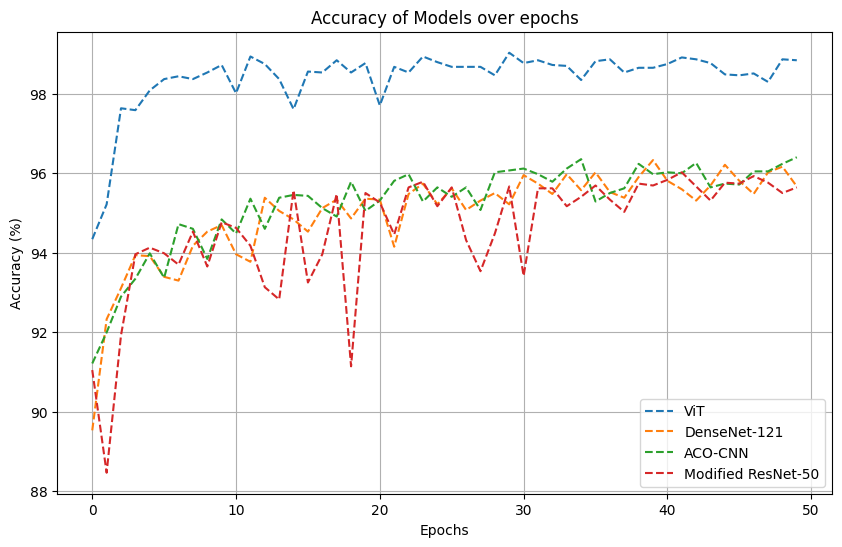

In [9]:
# Validation Accuracy Plot
plt.figure(figsize=(10, 6))
plt.plot(vit_val_accuracies, linestyle="--", label='ViT')
plt.plot(densenet_val_accuracies, linestyle="--", label='DenseNet-121')
plt.plot(val_accuracies_CNN, linestyle="--", label='ACO-CNN')
plt.plot(resnet50_val_accuracies, linestyle="--", label='Modified ResNet-50')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Models over epochs')
plt.xticks(ticks=range(0, num_epochs + 1, 10))  # Scale with intervals of 10 epochs
plt.legend()
plt.grid(True)
plt.show()

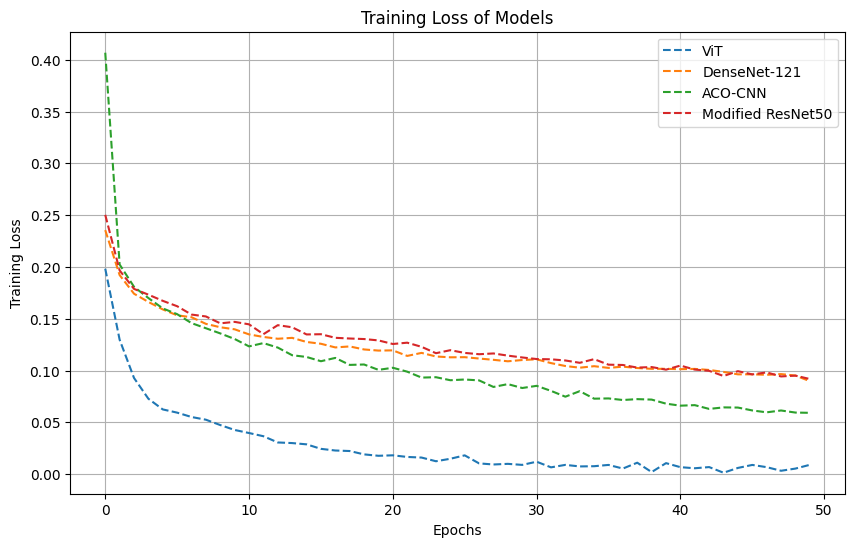

In [10]:
# Training Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(vit_train_losses, linestyle="--", label='ViT')
plt.plot(densenet_train_losses, linestyle="--", label='DenseNet-121')
plt.plot(train_losses_CNN, linestyle="--", label='ACO-CNN')
plt.plot(resnet50_train_losses, linestyle="--", label='Modified ResNet50')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss of Models')
plt.xticks(ticks=range(0, num_epochs + 1, 10))  # Scale with intervals of 10 epochs
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Dictionary to store metrics for each model
metrics_data = {
    "Model": ["ViT", "DenseNet-121", "ACO-CNN", "Modified ResNet50"],
    "Precision": [vit_precision, densenet_precision, precision_CNN, resnet50_precision],
    "Recall": [vit_recall, densenet_recall, recall_CNN, resnet50_recall],
    "F1 Score": [vit_f1, densenet_f1, f1_CNN, resnet50_f1]
}

# Convert to DataFrame and set 'Model' as the index
metrics_df = pd.DataFrame(metrics_data).set_index("Model")

# Display the table
print(metrics_df)


                   Precision    Recall  F1 Score
Model                                           
ViT                 0.985687  0.985792  0.985664
DenseNet-121        0.957946  0.958797  0.958188
ACO-CNN             0.959853  0.958797  0.959228
Modified ResNet50   0.958151  0.955245  0.956244
